In [208]:

import pandas as pd
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter
from lifelines.statistics import logrank_test,pairwise_logrank_test
import matplotlib.pyplot as plt

%matplotlib inline

In [157]:
#read the csv file
df_aero=pd.read_csv("removals.csv")


In [158]:
#checking the number of records

df_aero.shape

(10177, 15)

In [159]:
df_aero.head(5)

,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,SERIAL_NUMBER,INSTALL_DT,REMOVAL_DT,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,TIME_SINCE_INSTALL_CYCLES,TIME_SINCE_NEW_CYCLES
0,VST,479,737,27,WUQ009ZB,J47SA7GA3O,SATOCLV,2/16/2019 02:31:00 PM,2/16/2019,22,0,NaN,NaN,0,0
1,VST,478,737,23,UV1QK3PU,VCFF5E1530,SJBEPWN,6/13/2016 02:54:51 PM,10/9/2018,16,9,366.0,74.0,2325,2410
2,VST,478,737,34,70J139RY,INMPMQTE8V,S49E8WE,2/23/2019 04:42:00 PM,2/25/2019,18,1,1.0,1.0,8,8
3,VST,479,737,46,2562CGF4,6HAG5HHU8K,S3TRZMY,10/11/2016 11:32:53 PM,10/26/2016,19,2,7.0,3.0,24,37
4,VST,479,737,22,ZPYPBIS7,Y4OG6SEB7W,SK7M6J3,5/10/2017 07:57:00 AM,5/11/2017,20,1,NaN,NaN,6,185772


In [160]:
#sort by removal date

df_aero= df_aero.sort_values(by='REMOVAL_DT')
df_aero.head(5)

,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,SERIAL_NUMBER,INSTALL_DT,REMOVAL_DT,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,TIME_SINCE_INSTALL_CYCLES,TIME_SINCE_NEW_CYCLES
3525,JUE,784,737,25,5XFAYUXC,UMZSMGX85Q,SQ6YBP3,1/4/2015 01:16:09 PM,1/1/2015,23,0,NaN,NaN,0,0
7859,VST,955,737,35,JXK1JF3A,LGKCSK7X1K,SI5IV02,12/12/2015 08:29:34 AM,1/1/2016,16,0,17.0,4.0,76,157
561,VST,478,737,35,JXK1JF3A,FDO7Z6CGG5,SSQ6RJS,12/1/2015 08:36:31 AM,1/1/2016,15,0,23.0,7.0,96,4784
4206,VST,955,737,27,NDHIN24J,OYDJ5GDV5Y,SVQBJL2,1/3/2016 09:52:47 AM,1/1/2016,16,0,NaN,NaN,0,0
6997,JUE,925,787,25,UGZSQC4M,TMLAGSDDGV,SHO261S,11/15/2015 11:00:44 AM,1/1/2016,11,1,15.0,NaN,197,325


In [161]:
#adding the event column

df_aero['PART_REMOVAL'] = 0

#multiple records will be fetched for a given serial no


#consider that the part removes at the last index
idx_last_record = df_aero.reset_index().groupby(by='SERIAL_NUMBER')['index'].last()
df_aero.at[idx_last_record, 'PART_REMOVAL'] = 1

In [162]:
df_aero.head(5)

,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,SERIAL_NUMBER,INSTALL_DT,REMOVAL_DT,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,TIME_SINCE_INSTALL_CYCLES,TIME_SINCE_NEW_CYCLES,PART_REMOVAL
3525,JUE,784,737,25,5XFAYUXC,UMZSMGX85Q,SQ6YBP3,1/4/2015 01:16:09 PM,1/1/2015,23,0,NaN,NaN,0,0,0
7859,VST,955,737,35,JXK1JF3A,LGKCSK7X1K,SI5IV02,12/12/2015 08:29:34 AM,1/1/2016,16,0,17.0,4.0,76,157,0
561,VST,478,737,35,JXK1JF3A,FDO7Z6CGG5,SSQ6RJS,12/1/2015 08:36:31 AM,1/1/2016,15,0,23.0,7.0,96,4784,0
4206,VST,955,737,27,NDHIN24J,OYDJ5GDV5Y,SVQBJL2,1/3/2016 09:52:47 AM,1/1/2016,16,0,NaN,NaN,0,0,0
6997,JUE,925,787,25,UGZSQC4M,TMLAGSDDGV,SHO261S,11/15/2015 11:00:44 AM,1/1/2016,11,1,15.0,NaN,197,325,1


# 1. Using the CoxPHFitter

      To calculate the probability of failure

In [163]:
df_aero_cox=df_aero

In [164]:
#check for missing values

print("missing values")
df_aero_cox.isnull().sum()

missing values


OPERATOR_CD                     0
AIRCRAFT_CD                     0
FLEET_CD                        0
CHAPTER_CD                      0
PART_GROUP_CD                   0
PART_NUMBER                     0
SERIAL_NUMBER                   0
INSTALL_DT                      0
REMOVAL_DT                      0
AIRCRAFT_AGE                    0
REPETITIVE_FAULT_QT             0
MEL_QTY                      2695
DELAY_QTY                    4042
TIME_SINCE_INSTALL_CYCLES       0
TIME_SINCE_NEW_CYCLES           0
PART_REMOVAL                    0
dtype: int64

<AxesSubplot:xlabel='MEL_QTY'>

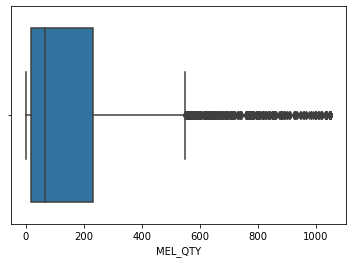

In [165]:
#check for outliers

import seaborn as sns

sns.boxplot(x=df_aero_cox['MEL_QTY'])


In [166]:
#since MEL_QTY has outliers missing values will be filled with median

df_aero_cox['MEL_QTY']= df_aero_cox['MEL_QTY'].fillna(df_aero_cox['MEL_QTY'].median())

In [167]:
df_aero_cox.isnull().sum()

OPERATOR_CD                     0
AIRCRAFT_CD                     0
FLEET_CD                        0
CHAPTER_CD                      0
PART_GROUP_CD                   0
PART_NUMBER                     0
SERIAL_NUMBER                   0
INSTALL_DT                      0
REMOVAL_DT                      0
AIRCRAFT_AGE                    0
REPETITIVE_FAULT_QT             0
MEL_QTY                         0
DELAY_QTY                    4042
TIME_SINCE_INSTALL_CYCLES       0
TIME_SINCE_NEW_CYCLES           0
PART_REMOVAL                    0
dtype: int64

In [168]:
df_aero_cox.head(5)

,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,SERIAL_NUMBER,INSTALL_DT,REMOVAL_DT,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,TIME_SINCE_INSTALL_CYCLES,TIME_SINCE_NEW_CYCLES,PART_REMOVAL
3525,JUE,784,737,25,5XFAYUXC,UMZSMGX85Q,SQ6YBP3,1/4/2015 01:16:09 PM,1/1/2015,23,0,68.0,NaN,0,0,0
7859,VST,955,737,35,JXK1JF3A,LGKCSK7X1K,SI5IV02,12/12/2015 08:29:34 AM,1/1/2016,16,0,17.0,4.0,76,157,0
561,VST,478,737,35,JXK1JF3A,FDO7Z6CGG5,SSQ6RJS,12/1/2015 08:36:31 AM,1/1/2016,15,0,23.0,7.0,96,4784,0
4206,VST,955,737,27,NDHIN24J,OYDJ5GDV5Y,SVQBJL2,1/3/2016 09:52:47 AM,1/1/2016,16,0,68.0,NaN,0,0,0
6997,JUE,925,787,25,UGZSQC4M,TMLAGSDDGV,SHO261S,11/15/2015 11:00:44 AM,1/1/2016,11,1,15.0,NaN,197,325,1


In [169]:
#since delay qty is a time series data, missing values will be handled using forward fill

df_aero_cox['DELAY_QTY']= df_aero_cox['DELAY_QTY'].fillna(method='ffill')


In [170]:
df_aero_cox.isnull().sum()

OPERATOR_CD                  0
AIRCRAFT_CD                  0
FLEET_CD                     0
CHAPTER_CD                   0
PART_GROUP_CD                0
PART_NUMBER                  0
SERIAL_NUMBER                0
INSTALL_DT                   0
REMOVAL_DT                   0
AIRCRAFT_AGE                 0
REPETITIVE_FAULT_QT          0
MEL_QTY                      0
DELAY_QTY                    1
TIME_SINCE_INSTALL_CYCLES    0
TIME_SINCE_NEW_CYCLES        0
PART_REMOVAL                 0
dtype: int64

In [171]:
#dropping the first row as forward fill refers to the previous value
df_aero_cox = df_aero.dropna(axis=0)

In [172]:
df_aero_cox.shape

(10176, 16)

In [173]:
df_aero_cox.to_csv('removals_cox.csv')

In [174]:
#check datatypes in the dataframe

df_aero_cox.dtypes

OPERATOR_CD                   object
AIRCRAFT_CD                    int64
FLEET_CD                       int64
CHAPTER_CD                     int64
PART_GROUP_CD                 object
PART_NUMBER                   object
SERIAL_NUMBER                 object
INSTALL_DT                    object
REMOVAL_DT                    object
AIRCRAFT_AGE                   int64
REPETITIVE_FAULT_QT            int64
MEL_QTY                      float64
DELAY_QTY                    float64
TIME_SINCE_INSTALL_CYCLES      int64
TIME_SINCE_NEW_CYCLES          int64
PART_REMOVAL                   int64
dtype: object

In [175]:
#take only numeric columns
df_aero_cox=df_aero_cox.select_dtypes(include='number')
df_aero_cox

,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,TIME_SINCE_INSTALL_CYCLES,TIME_SINCE_NEW_CYCLES,PART_REMOVAL
7859,955,737,35,16,0,17.0,4.0,76,157,0
561,478,737,35,15,0,23.0,7.0,96,4784,0
4206,955,737,27,16,0,68.0,7.0,0,0,0
6997,925,787,25,11,1,15.0,7.0,197,325,1
25,955,737,52,17,0,68.0,7.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6007,784,737,27,23,2,632.0,43.0,2290,2290,1
3531,784,737,25,24,8,306.0,20.0,1106,1106,1
6093,763,737,21,16,9,651.0,19.0,2020,2020,1
6408,763,737,32,18,0,38.0,4.0,120,303,1


In [176]:
#Using the COXPHFitter
from lifelines import CoxPHFitter


#consider only numeric columns



cph = CoxPHFitter()
cph.fit(df_aero_cox, duration_col='TIME_SINCE_INSTALL_CYCLES', event_col='PART_REMOVAL')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10176 total observations, 3503 right-censored observations>
             duration col = 'TIME_SINCE_INSTALL_CYCLES'
                event col = 'PART_REMOVAL'
      baseline estimation = breslow
   number of observations = 10176
number of events observed = 6673
   partial log-likelihood = -51782.24
         time fit was run = 2021-12-07 05:07:29 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
AIRCRAFT_CD             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
FLEET_CD               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CHAPTER_CD             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AIRCRAFT_AGE            0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
REPETITIVE_FAULT_QT    -0.02       0.98       0.00            -0.03            -0.02                 0.97                 0.98
MEL_QTY                -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
DELAY_QTY              -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
TIME_SINCE_NEW_CYCLES  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                           z      p   -log2(p)
covariate                                     
AIRCRAFT_CD             0.88   0.38       1.40
FLEET_CD               -0.74   0.46       1.13
CHAPTER_CD             -1.81   0.07       3.83
AIRCRAFT_AGE            6.07 <0.005      29.54
REPETITIVE_FAULT_QT    -9.97 <0.005      75.29
MEL_QTY               -38.53 <0.005        inf
DELAY_QTY              -7.48 <0.005      43.65
TIME_SINCE_NEW_CYCLES -19.14 <0.005     268.90
---
Concordance = 0.70
Partial AIC = 103580.48
log-likelihood ratio test = 4447.16 on 8 df
-log2(p) of ll-ratio test = inf

FLEET_CD,CHAPTER_CD,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY and TIME_SINCE_NEW_CYCLES are statistically significant since the probability is less than p<0.005

MEL_QTY, TIME_SINCE_NEW_CYCLES has a exp(coefficient) of about 1. Thus, a one unit increase in MEL_QTY means the the baseline hazard will increase by a factor of exp(-0.00)=1.0 - about a 1% increase. In the Cox proportional hazard model, a higher hazard means more at risk of the event occurring. The value exp(-0.00) is called the hazard ratio.

<AxesSubplot:xlabel='log(HR) (95% CI)'>

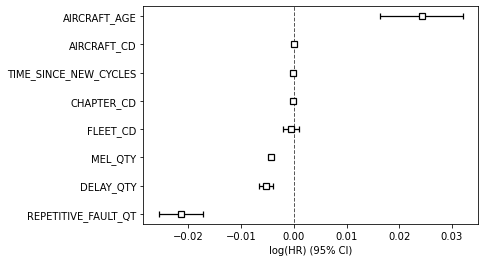

In [210]:
#to view the coefficient 

cph.plot()

In [228]:
df_aero_cox.DELAY_QTY.unique()

array([  4.,   7.,  13.,   1.,  30.,  26.,  11.,  59.,   5.,   2.,   6.,
         8.,  17.,  27.,   3.,  20., 114.,  16.,  10.,  12.,  33.,  15.,
        21., 106.,  32.,  18.,  22.,   9.,  43.,  28.,  75.,  25.,  44.,
        23.,  14.,  65.,  35.,  29.,  41.,  36.,  31.,  51.,  24.,  39.,
        19., 108.,  37.,  49.,  90.,  63.,  70.,  93.,  87.,  67.,  40.,
        78.,  45., 102.,  62.,  69.,  46.,  48.,  56.,  58.,  74.,  50.,
        34., 113., 103.,  73.,  47.,  77.,  38.,  91., 101.,  92., 107.,
       117.,  85.,  54., 118.,  55., 109., 104.,  42.,  71.,  60.,  52.,
        97.,  88.,  86.,  61.,  57., 119.,  68.,  53.,  89.,  98.,  96.,
        81.,  76.,  64., 111.,  80.,  72., 110., 120.,  82., 100.,  95.,
        99.,  79., 116.,  66., 115.,  84., 105., 112.,  94.])

In [219]:
df_aero_cox.MEL_QTY

7859     17.0
561      23.0
4206     68.0
6997     15.0
25       68.0
        ...  
6007    632.0
3531    306.0
6093    651.0
6408     38.0
3489     31.0
Name: MEL_QTY, Length: 10176, dtype: float64

In [227]:
df_aero_cox["DELAY_QTY"].max()

120.0

In [221]:
df_aero_cox["DELAY_QTY"].min()

1.0

<AxesSubplot:>

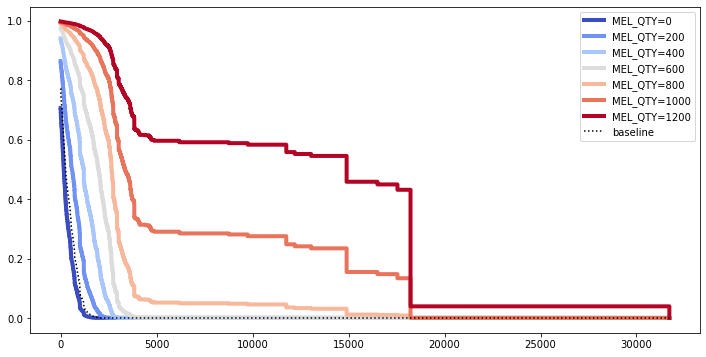

In [216]:
cph.plot_partial_effects_on_outcome(covariates='MEL_QTY', values=[0, 200, 400, 600, 800, 1000, 1200], cmap='coolwarm',linewidth=4,figsize=(12,6))

From the above chart, we can see that when the MEL_QTY is high, the probability of part being failed is also high.



* CHAPTER_CD, REPETITIVE_FAULT_QT, MEL_QTY, DELAY_QTY, TIME_SINCE_NEW_CYCLES can be considered as statistically significant

In [206]:
#add the model to pickel

import pickle

with open('survival_cph_pkl', 'wb') as files:
    pickle.dump(cph, files)



In [ ]:
with open('survival_cph_pkl' , 'rb') as f:
    lr = pickle.load(f)

# 2. Using KaplanMeierFitter

In [205]:
#create object for KaplanMeierFitter

kmf = KaplanMeierFitter()

#fit the values

kmf.fit(df_aero['TIME_SINCE_INSTALL_CYCLES'], df_aero['PART_REMOVAL'], label="Kaplan Meier Estimate")

<lifelines.KaplanMeierFitter:"Kaplan Meier Estimate", fitted with 10177 total observations, 3504 right-censored observations>

Text(0, 0.5, 'Survival Probability')

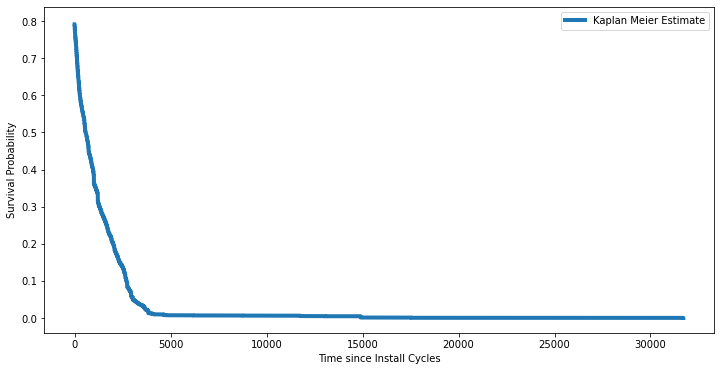

In [209]:
kmf.plot(linewidth=4,figsize=(12,6))
plt.xlabel('Time since Install Cycles')
plt.ylabel('Survival Probability')

In [204]:
#event table

kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,2851,2123,728,10177,10177
1,17,12,5,0,7326
2,61,28,33,0,7309
3,12,9,3,0,7248
4,42,16,26,0,7236
...,...,...,...,...,...
14899,14,14,0,0,19
16505,1,1,0,0,5
17547,2,2,0,0,4


In [49]:
df_aero_kmf=df_aero